In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from math import log
import matplotlib 
matplotlib.rc('xtick', labelsize=20) 
matplotlib.rc('ytick', labelsize=20) 

In [18]:
d = dict()

d[1] = 'a'
d[2] = 'b'

d.values()

dict_values(['a', 'b'])

In [27]:
d.keys()

dict_keys([1, 2])

In [5]:
s = "A man, a plan, a canal: Panama"

In [17]:
"".join(char.lower() for char in s if char.isalnum())

'amanaplanacanalpanama'

In [13]:
re.sub('[^a-z\d]+','',s.lower())

'amanaplanacanalpanama'

In [7]:
s == s[::-1]

False

# Parameters 

In [2]:
# First part - default params
share = "TATN"
date = "20150310"
tick = 5
phase_param = 1.5

In [3]:
# Second part - optimization for hard jma
tick_list = list(range(3, 12, 3))
phase_param_list = [0.5, 1.5, 2.5]
tick_list

[3, 6, 9]

In [4]:
test_data_1 = [4, 5, 6, 7, 8, 9, 10]
test_data_2 = [14, 15, 16, 17, 18, 19, 22] 

# Benchmarks and realization

In [5]:
def jma(test, leng=10, phaseRatio=1):
    length = len(test)
    power = 1

    beta = 0.45 * (length - 1) / (0.45 * (length - 1) + 2)
    alpha = pow(beta, power)
    jma = test[-1]

    e0 = jma
    e1 = 0.0
    e2 = 0.0
    test = test[-leng:]
    #print(test)
    #print("precalc", alpha, beta, phaseRatio)
    for trade in test:
        e0 = (1 - alpha) * trade + alpha * e0
        e1 = (trade - e0) * (1 - beta) + beta * e1
        e2 = (e0 + phaseRatio * e1 - jma) * pow(1 - alpha, 2) + pow(alpha, 2) * e2
        jma = e2 + jma
    return jma

def sma(data):
    return np.array(data).mean()


def wma(data):
    leng = len(data)
    weights = np.arange(1, leng + 1)
    wmas = (np.array(data) * weights) / weights.sum()
    return wmas.sum()


def ema(data):
    values = pd.DataFrame(np.array(data))
    return round(values.ewm(span=10).mean().iat[-1, 0], 1)

In [6]:
jma(test_data_1), sma(test_data_1), wma(test_data_1), ema(test_data_1)

(7.630720480065019, 7.0, 8.0, 7.8)

In [7]:
jma(test_data_2), sma(test_data_2), wma(test_data_2), ema(test_data_2)

(17.979747611897174, 17.285714285714285, 18.5, 18.3)

In [94]:

fol = pd.read_csv("../MOEX/OrderLog" + date + "/TradeLog" + date + ".txt", sep=',')
test_data_1 = fol[fol["SECCODE"] == share]

In [95]:
test_data_1 = fol[fol["SECCODE"] == share]
#tatn = tatn[tatn["ACTION"] == 2]
#test_data_1 = test_data_1[test_data_1["TIME"] < 100050]
test_data_1 = test_data_1[test_data_1["PRICE"] != 0.0]
test_data_1 = test_data_1["PRICE"]
test_data_1.head()

251    296.40
404    296.40
405    296.45
604    296.45
664    296.45
Name: PRICE, dtype: float64

# Hard JMA Version

In [96]:
class Jma_hard:
    def __init__(self, avg_len=65, jma_leng=12, phase_param=1, avg_vol_len=10):
        # first initialization
        self.avg_len = avg_len
        self.jma_leng = jma_leng
        self.phase_param = phase_param
        self.avg_vol_len = avg_vol_len
        self.len_0 = (jma_leng - 1) / 2
        self.len_1 = max(log(self.len_0) / (2 * log(2)) + 2, 0)
        self.len_2 = self.len_1 * (self.len_0 ** 0.5)
        self.beta_2 = self.len_2 / (self.len_2 + 1)
        self.kv = self.beta_2
        self.pow_1 = max(self.len_1 - 2, 0.5)
        self.beta = 0.45 *(self.jma_leng - 1) / (0.45 * (self.jma_leng - 1) + 2)
        self.alpha = self.beta
        #self.upper_band, self.lower_band, self.m1, self.m2, self.jma = test[0], test[0], test[0], test[0], test[0]
        self.initialized = False
        self.delta_1, self.delta_2, self.volty, self.v_sum, self.avg_volty, self.t0, self.t1 = 0, 0, 0, 0, 0, 0, 0
        self.r_volty, self.power = 1, 1
        self.volty_history = [0]
    
    
    def iterate_by_test_data(self, test):
        output = []
        for price in test:
            output.append(self.calc_jma(price))
        return output
            
    
    def calc_jma(self, price):
        if not self.initialized:
            self.initialized = True
            self.upper_band, self.lower_band, self.m1, self.m2, self.jma = price, price, price, price, price
        self.delta_1 = price - self.upper_band
        self.delta_2 = price - self.lower_band
        if abs(self.delta_1) == abs(self.delta_2):
            volty = 0
        else:
            volty = max(abs(self.delta_1), abs(self.delta_2))
        self.volty_history.append(volty)
        self.v_sum = np.array(self.volty_history[-10:]).mean()
        self.avg_volty = self.avg_volty + 2 * (self.v_sum - self.avg_volty) / (self.avg_len + 1)
        if self.avg_volty > 0:
            self.r_volty = max(min(volty / self.avg_volty, self.len_1 ** (1 / self.pow_1)), 1)
        else:
            self.r_volty = 1
        self.power = self.r_volty ** self.pow_1
        self.alpha = self.beta ** self.power
        self.kv = self.beta_2 ** (self.power ** 0.5)
        
        if self.delta_2 < 0:
            self.lower_band = price
        else:
            self.lower_band = price - self.kv * self.delta_2
        if self.delta_1 > 0:
            self.upper_band = price
        else:
            self.upper_band = price - self.kv * self.delta_1
            
        self.m1 = (1 - self.alpha) * price + self.alpha * self.m1
        self.t0 = (price - self.m1) * (1 - self.beta) + (self.beta * self.t0)
        self.m2 = self.m1 + self.t0 * self.phase_param
        self.t1 = (self.m2 - self.jma) * (1 - self.alpha) * (1 - self.alpha) + (self.alpha ** 2) * self.t1
        self.jma = self.jma + self.t1
        return self.jma


In [98]:
def get_diff(ma_data, price, period):
    return (ma_data - price.shift(periods=period)).abs().sum()

In [154]:
def create_graph(dict_of_result, price, period, tick, title='Absolute difference sum between MA price and forward price by period ' + str(period) \
              + ", MA ticks - " + str(tick)):
    result_lst = []
    for res in dict_of_result:
        result_lst.append(get_diff(dict_of_result[res], price, period))
    candidate_names = np.array(list(dict_of_result.keys()))
    result_lst = np.array(result_lst)
    sorted_index =  np.argsort(result_lst)
    plt.bar(candidate_names[sorted_index], result_lst[sorted_index])
    plt.title(title, fontsize=20)
    plt.xticks(rotation=90)
    plt.show()
    return result_lst

In [155]:
get_diff(test_data_1, test_data_1, 1)

913.6499999999967

In [156]:
data = list(test_data_1)
price_list = []
ema_list = []
sma_list = []
wma_list = []
jma_light_list = []

for i in range(len(data)):
    price_list.append(data[i])
    ema_list.append(ema(data[max(0,i - tick):i + 1]))
    sma_list.append(sma(data[max(0,i - tick):i + 1]))
    wma_list.append(wma(data[max(0,i - tick):i + 1]))
    jma_light_list.append(jma(data[max(0,i - tick):i + 1]))
    
hard_jma = Jma_hard(jma_leng=tick, avg_len=65, phase_param=phase_param, avg_vol_len=10)

hard_jma_res = hard_jma.iterate_by_test_data(test_data_1)

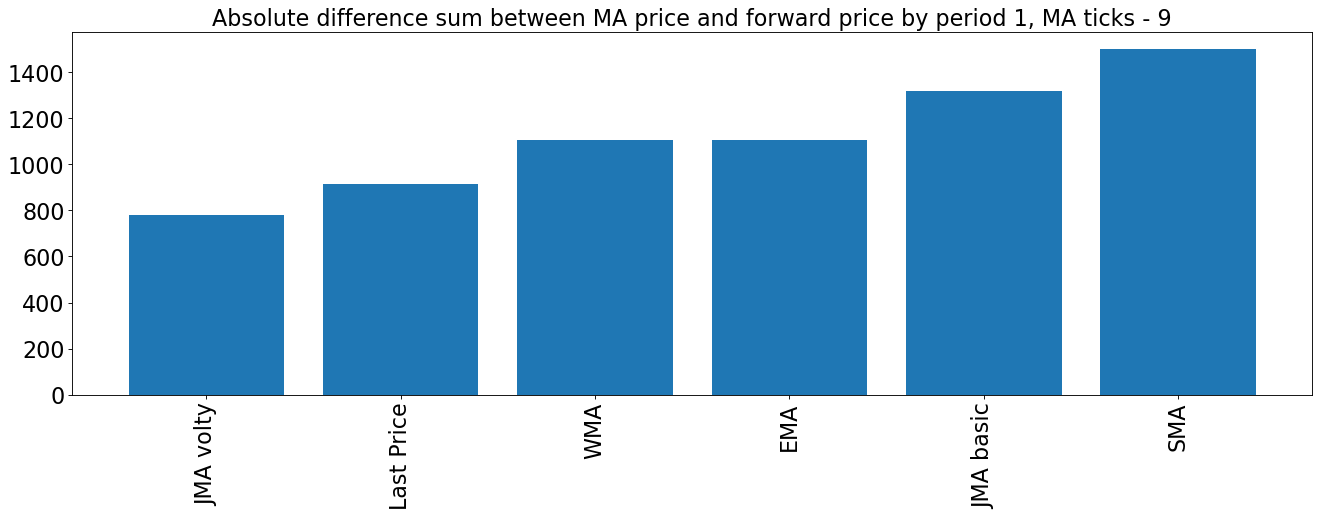

In [157]:
period = 1
plt.figure(figsize=(20, 6), dpi=80)
candidates = {"SMA": sma_list,
             "WMA": wma_list,
             "EMA": ema_list,
             "JMA basic": jma_light_list,
             "JMA volty": hard_jma_res,
             "Last Price": test_data_1}
res = create_graph(candidates, test_data_1, period, tick)

In [3]:
for i, j in zip(range(5), range(5)):
    print(i, j)

0 0
1 1
2 2
3 3
4 4


# Optimization part

In [158]:
candidates = dict()

In [159]:
for tick in tick_list:
    for phase_param in phase_param_list:
        hard_jma = Jma_hard(jma_leng=tick, avg_len=65, phase_param=phase_param, avg_vol_len=10)
        candidates["tick - " + str(tick) + ",phase - " + str(phase_param)] = hard_jma.iterate_by_test_data(test_data_1)

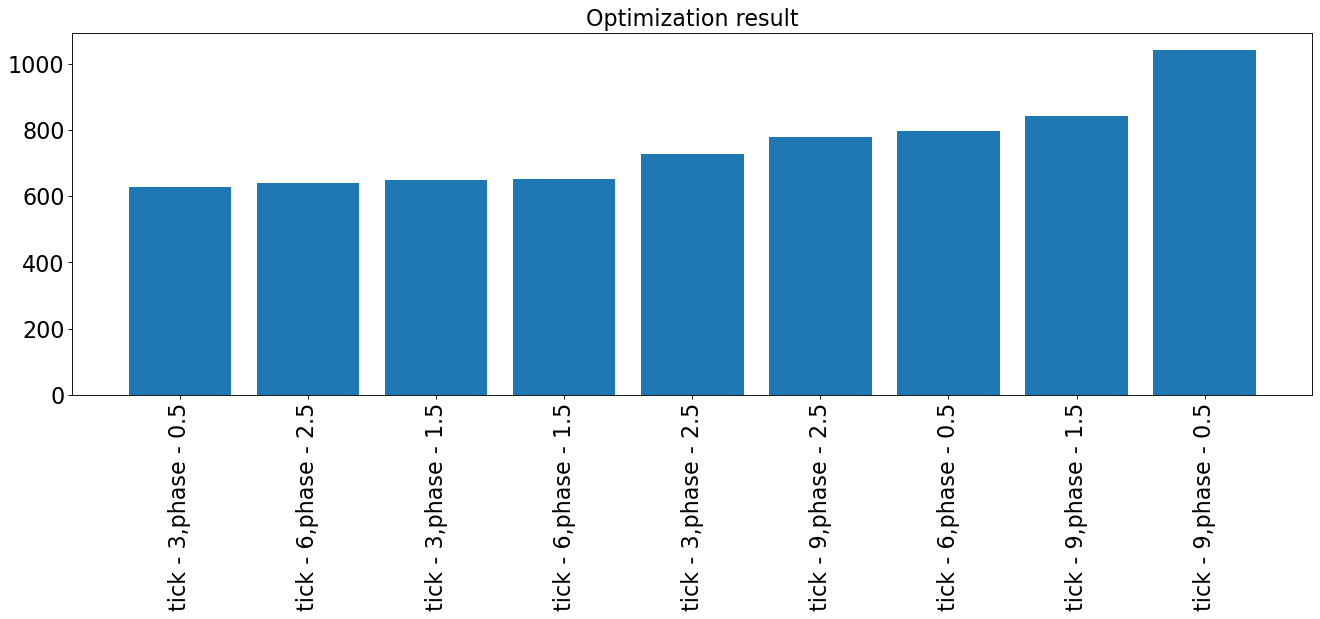

In [160]:
plt.figure(figsize=(20, 6), dpi=80)
res = create_graph(candidates, test_data_1, period, tick, title="Optimization result")